In [1]:
from datetime import datetime, timedelta

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Importing Time Series Data

# Data by the hour
first_48_data = pd.read_csv('/content/drive/MyDrive/revised_first_48_by_hr.csv')
first_48_data = first_48_data.dropna(axis=1, how='all')

first_48_data.head()

,Unnamed: 0,time_since_start,measurement_datetime,person_id,visit_occurrence_id,visit_start_datetime,visit_end_datetime,ART BP Diastolic,Arterial Blood Pressure diastolic,Non Invasive Blood Pressure diastolic,...,Admission Weight,pH|Blood|Blood Gas,PH (Arterial),readmission_freq,readmission_id,readmission_time,time_between_readmission,readmission_label,death_label,length_of_stay
0,0,0 days 00:00:00.000000000,2174-05-26 04:20:00,-8090189584974691216,-9133360720296560252,2174-05-26 04:20:00,2174-05-31 14:15:00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,129.916667
1,1,0 days 01:00:00.000000000,2174-05-26 05:20:00,-8090189584974691216,-9133360720296560252,2174-05-26 04:20:00,2174-05-31 14:15:00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,129.916667
2,2,0 days 02:00:00.000000000,2174-05-26 06:20:00,-8090189584974691216,-9133360720296560252,2174-05-26 04:20:00,2174-05-31 14:15:00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,129.916667
3,3,0 days 03:00:00.000000000,2174-05-26 07:20:00,-8090189584974691216,-9133360720296560252,2174-05-26 04:20:00,2174-05-31 14:15:00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,129.916667
4,4,0 days 04:00:00.000000000,2174-05-26 08:20:00,-8090189584974691216,-9133360720296560252,2174-05-26 04:20:00,2174-05-31 14:15:00,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,129.916667


In [3]:
# Converting timedelta string to float 

time_deltas = first_48_data['time_since_start'].apply(lambda x : pd.to_timedelta(x))

time_delta_floats = time_deltas.apply(lambda x : x / np.timedelta64(1, 'm'))

first_48_data['time_since_start'] = time_delta_floats

print(first_48_data.head())

   Unnamed: 0  time_since_start measurement_datetime            person_id  \
0           0               0.0  2174-05-26 04:20:00 -8090189584974691216   
1           1              60.0  2174-05-26 05:20:00 -8090189584974691216   
2           2             120.0  2174-05-26 06:20:00 -8090189584974691216   
3           3             180.0  2174-05-26 07:20:00 -8090189584974691216   
4           4             240.0  2174-05-26 08:20:00 -8090189584974691216   

   visit_occurrence_id visit_start_datetime   visit_end_datetime  \
0 -9133360720296560252  2174-05-26 04:20:00  2174-05-31 14:15:00   
1 -9133360720296560252  2174-05-26 04:20:00  2174-05-31 14:15:00   
2 -9133360720296560252  2174-05-26 04:20:00  2174-05-31 14:15:00   
3 -9133360720296560252  2174-05-26 04:20:00  2174-05-31 14:15:00   
4 -9133360720296560252  2174-05-26 04:20:00  2174-05-31 14:15:00   

   ART BP Diastolic  Arterial Blood Pressure diastolic  \
0               NaN                                NaN   
1           

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features

feature_data = first_48_data[first_48_data.columns[7:-7]]
print(feature_data.head())

std_scaler = StandardScaler()

std_scaler.fit(feature_data)

scaled_X = std_scaler.transform(feature_data)

scaled_X_df = pd.DataFrame(scaled_X, columns=first_48_data.columns[7:-7])

first_48_data[first_48_data.columns[7:-7]] = scaled_X

   ART BP Diastolic  Arterial Blood Pressure diastolic  \
0               NaN                                NaN   
1               NaN                                NaN   
2               NaN                                NaN   
3               NaN                                NaN   
4               NaN                                NaN   

   Non Invasive Blood Pressure diastolic  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

   Manual Blood Pressure Diastolic Left  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Manual Blood Pressure Diastolic Right  Inspired O2 Fraction  \
0                                    NaN                   Na

In [5]:
# Grouping by admission

data = first_48_data.groupby('visit_occurrence_id')
print(len(data))

124


In [6]:
# Creating the feature and label data
y_readmission = []
y_mortality = []
y_los = []

i = 0

for group_idx, group_rows in data:

  j = 0

  y_readmission.append(group_rows['readmission_label'].values[0])
  y_mortality.append(group_rows['death_label'].values[0])
  y_los.append(group_rows['length_of_stay'].values[0])

  for idx, row in group_rows.iterrows():
    
    # entry of the matrix
    cur_time_entry = []

    # Creating the row with the necessary feature values
    #cur_time_entry.append(row['time_since_start'])
    
    for feature_name in first_48_data.columns[7:-7]:
      cur_time_entry.append(row[feature_name])

    cur_time_entry = np.array([cur_time_entry])

    
    # To ensure that this works to insert the first row
    if j == 0:

      # matrix of the time series
      X_element = np.array(cur_time_entry)
      
    else:
      X_element = np.concatenate((X_element, np.array(cur_time_entry)))
    
    j += 1

    
  
  # To ensure that this works to insert the first matrix
  if i == 0:

    # Holds all of the multivariate time series
    X = [X_element]
    
  else:
    X = np.concatenate((X, [X_element]))
  
  i += 1

  
  


X_columns = []
#X_columns.append(first_48_data.columns[1])

for feature_name in first_48_data.columns[7:-7]:
  X_columns.append(feature_name)

y_readmission = pd.Series(y_readmission, name='readmission_label')
y_mortality = pd.Series(y_mortality, name='death_label')
y_los = pd.Series(y_los, name='length_of_stay')

y = { 'readmission_label': y_readmission,
       'death_label': y_mortality,
       'length_of_stay': y_los 
}

y = pd.DataFrame(y)

print(len(X))
print(len(y))


124
124


In [9]:
from sklearn.model_selection import train_test_split

# Preparing the train and test sets
def balanced_train_test_split(X, y):
  while(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    mortality_y_train = y_train['death_label']
    mortality_y_test = y_test['death_label']
    
    prop_positive = len(np.where(mortality_y_test == 1)) / len(np.where(y['death_label'] == 1)) 
     
    if prop_positive >= 0.2:
      print(np.where(mortality_y_test == 1))
      break

  return X_train, X_test, y_train, y_test


In [10]:
 X_train, X_test, y_train, y_test = balanced_train_test_split(X, y)

(array([ 2,  6,  7, 20]),)


In [11]:
from sklearn.impute import SimpleImputer


print(X.shape)

train_feature_means = []

# Reshaping to 2-dimensional data for imputation
X_train_2d = np.reshape(X_train, (99*48, 35))


train_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_mean_imputer.fit(X_train_2d)
X_train_2d = train_mean_imputer.transform(X_train_2d)


for i in range(X_train_2d.shape[1]):
  train_feature_means.append(np.mean(X_train_2d[:][i]))



print(train_feature_means)

(124, 48, 35)
[0.0373490292322291, 0.0373490292322291, 0.0373490292322291, 0.0373490292322291, 0.03597609258640947, 0.039717549418736994, -0.07057858583747331, 0.007299376307830534, -0.061395411232063525, -0.024982003870954932, -0.001486424529856481, 0.14101326822251994, 0.01190366691248264, 0.03132000182428588, -0.005515852441152342, -0.0001931601062763621, -0.07342391323754627, 0.028247227984927344, 0.03554779464180281, 0.08590065426268852, 0.04273291315007864, -0.0010475361487406714, 0.10179098983591817, 0.1017814865462288, 0.03445443860480352, 0.00022757435658054984, 0.03370061832596056, 0.1320225891612314, 0.0807371430480259, 0.07555240616723223, 0.11727925594020025, 0.15112083210455993, -0.030324929527357294, -0.0140139563831042, 0.0373490292322291]


In [12]:
from sklearn.impute import SimpleImputer


print(X.shape)

test_feature_means = []

# Reshaping to 2-dimensional data for imputation
X_test_2d = np.reshape(X_test, (25*48, 35))


test_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
test_mean_imputer.fit(X_test_2d)
X_test_2d = test_mean_imputer.transform(X_test_2d)


for i in range(X_test_2d.shape[1]):
  test_feature_means.append(np.mean(X_test_2d[:][i]))



print(test_feature_means)

(124, 48, 35)
[-0.19695384038407346, -0.19695384038407346, -0.19695384038407346, -0.19695384038407346, -0.19695384038407346, -0.19695384038407346, -0.6514260242427226, -0.2977983017385706, -0.02683252194705933, -0.2327509695477523, -0.27737466886176354, -0.24338871426238895, -0.06303971484771395, -0.28243787535460546, -0.13480021290647815, -0.30315692513436926, -0.29801075719866965, -0.31344516760923063, -0.10287072252894008, -0.3022773909180368, -0.2943700114485993, -0.37266161895017064, -0.29691125638344923, -0.1076520246359438, -0.2621288240807947, -0.21090938203162768, -0.04277639096519147, -0.3246635659971022, -0.28983949243917495]


In [13]:
# Creating a random mask for evaluation of imputation 

def mean_imputation_eval(X, train_feature_means, test_feature_means=None):
  iter = 2000
  mse_list = []
  mae_list = []

  n_samples = X.shape[0]

  rand_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
  mask_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
  rand_mask = np.empty([X.shape[0], X.shape[1], X.shape[2]])

  for j in range(iter):

    for i in range(rand_X_imputed.shape[0]):
      rand_mask[i] = np.random.randint(2, size=(48, 35))

    mse = 0
    mae = 0

    # Actual mask of observations for comparison
    mask_X_imputed = np.where(np.isnan(X), 0, X)
    mask_X = np.where(np.isnan(X), 0, 1)
    # Random mask for evaluation
    rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
    #print(rand_X_test_imputed[i])

    #print(mask_X_test_imputed[i].shape)

    # imputing on the random mask data
    rand_X_imputed = np.where(np.isnan(rand_X_imputed), train_feature_means,  rand_X_imputed)
    
    #print(rand_X_test_imputed)


    rand_X_imputed = np.where(np.isnan(X), 0, rand_X_imputed)
      
    for i in range(rand_X_imputed.shape[0]):
      # mse += np.mean(np.square(np.subtract(mask_X_imputed[i], rand_X_imputed[i])))
      # mae += np.mean(np.absolute(np.subtract(mask_X_imputed[i], rand_X_imputed[i])))
      mse += np.sum(np.square(np.subtract(mask_X_imputed[i], rand_X_imputed[i]))) / np.sum(mask_X[i])
      mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], rand_X_imputed[i]))) / np.sum(mask_X[i])

    mse_list.append(mse / n_samples)
    mae_list.append(mae / n_samples)


  print("mse:")
  print(np.mean(mse_list))
  print(np.var(mse_list), "\n")


  print("mae:")
  print(np.mean(mae_list))
  print(np.var(mae_list), "\n")

In [14]:
mean_imputation_eval(X, train_feature_means)

mse:
0.581032312781591
0.014821267460382719 

mae:
0.3993161111881436
0.000630250892139529 



In [15]:
def create_mean_imputed_data(X_train, X_test, train_feature_means, test_feature_means=None):
  impute_value = 0.

  X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

  train_mask = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  test_mask = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        if np.isnan(X_train[i,j,k]):
          X_train_imputed[i,j,k] = train_feature_means[k]
          train_mask[i,j,k] = 0
        else:
          X_train_imputed[i,j,k] = X_train[i,j,k]
          train_mask[i,j,k] = 1


  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        if np.isnan(X_test[i,j,k]):
          X_test_imputed[i,j,k] = train_feature_means[k]
          test_mask[i,j,k] = 0
        else:
          X_test_imputed[i,j,k] = X_test[i,j,k]
          test_mask[i,j,k] = 1

  return X_train_imputed, X_test_imputed
    

In [16]:
X_train_mean_imputed, X_test_mean_imputed = create_mean_imputed_data(X_train, X_test, train_feature_means)

In [17]:
def vae_preprocessing(X_train, X_test):
  impute_value = 0.

  X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

  train_mask = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  test_mask = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        if np.isnan(X_train[i,j,k]):
          X_train_imputed[i,j,k] = impute_value
          train_mask[i,j,k] = 0
        else:
          X_train_imputed[i,j,k] = X_train[i,j,k]
          train_mask[i,j,k] = 1


  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        if np.isnan(X_test[i,j,k]):
          X_test_imputed[i,j,k] = impute_value
          test_mask[i,j,k] = 0
        else:
          X_test_imputed[i,j,k] = X_test[i,j,k]
          test_mask[i,j,k] = 1
  return X_train_imputed, X_test_imputed, train_mask, test_mask

In [18]:
processed_X_train, processed_X_test, train_mask, test_mask = vae_preprocessing(X_train, X_test)

In [19]:
from abc import ABC, abstractmethod

class vae_model(ABC):
  def __init__(self):
    self.latent_dim = 2
    self.sequence_length = 48

  def set_seed(self, seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

  def sampling(self, args):
      
    latent_dim = 2
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon


  def vae_loss(self, inp, mask, out, z_log_sigma, z_mean):
    masked_input = tf.math.multiply(inp, mask)
    masked_output = tf.math.multiply(out, mask)

    #mse = np.sum(np.square(np.subtract(masked_output, masked_input))) / np.sum(mask)
    mse = K.sum(K.square(masked_output - masked_input)) / K.sum(mask)

    reconstruction = mse * self.sequence_length
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

    return reconstruction + kl

  @abstractmethod
  def get_model(self):
    pass
   


In [20]:
class cnn_vae(vae_model):

  def get_model(self):
  

    self.set_seed(33)

    # encoder
    
    inp = Input(shape=(self.sequence_length, 35))
    mask = Input(shape=(self.sequence_length, 35))
    
    concat = Concatenate()([inp])
  
    #enc = LSTM(192, input_shape=(48, 36))(concat)

    conv = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation='relu')(concat)
    print(conv.shape)

    max_pool = tf.keras.layers.MaxPool1D(pool_size = 2)(conv) 

    conv = tf.keras.layers.Conv1D(filters = 8, kernel_size = 3, activation='relu')(max_pool)
    print(conv.shape)
    
    enc = tf.keras.layers.Flatten()(conv)

    enc = Dense(21*8, activation="relu")(enc)

    enc = Dense(21*4, activation="relu")(enc)

    z = Dense(21*2, activation="relu")(enc)
      
    z_mean = Dense(self.latent_dim)(z)
    z_log_sigma = Dense(self.latent_dim)(z)

    encoder = Model([inp], [z_mean, z_log_sigma])
    
    # decoder
    
    inp_z = Input(shape=(self.latent_dim,))

    dec = Dense(21*2)(inp_z)

    dec = Dense(21*4)(dec)

    dec = Dense(21*8)(dec)

    dec = Concatenate()([dec])
    dec = Reshape((21, 8))(dec)

    deconv = tf.keras.layers.Conv1DTranspose(filters=16, kernel_size=3)(dec)
    print(deconv.shape)

    upsample = tf.keras.layers.UpSampling1D(2)(deconv)

    deconv = tf.keras.layers.Conv1DTranspose(filters=35, kernel_size=3)(upsample)
    print(deconv.shape)

    
    out = deconv
    

    decoder = Model([inp_z], out) 
    
    # encoder and decoder 

    z_mean, z_log_sigma = encoder([inp])
    z = Lambda(self.sampling)([z_mean, z_log_sigma])
    pred = decoder([z])

    vae = Model([inp,  mask], pred)
    vae.add_loss(self.vae_loss(inp, mask, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(learning_rate=1e-4))
    
    return vae

In [21]:
class lstm_vae(vae_model):


  def get_model(self):
      
    self.set_seed(33)


    
    # encoder 
    
    inp = Input(shape=(self.sequence_length, 35))
    mask = Input(shape=(self.sequence_length, 35))
    
    concat = Concatenate()([inp])
  
    enc = LSTM(192, input_shape=(48, 35))(concat)
    
    z = Dense(96, activation="relu")(enc)
        
    z_mean = Dense(self.latent_dim)(z)
    z_log_sigma = Dense(self.latent_dim)(z)

    encoder = Model([inp], [z_mean, z_log_sigma])
    
    # decoder
    
    inp_z = Input(shape=(self.latent_dim,))

    dec = RepeatVector(self.sequence_length)(inp_z)
    
    dec = Concatenate()([dec])
    dec = LSTM(192, input_shape=(48, 35), return_sequences=True)(dec)
    
    out = TimeDistributed(Dense(35))(dec)
    

    decoder = Model([inp_z], out) 
    
    # encoder and decoder 

    z_mean, z_log_sigma = encoder([inp])
    z = Lambda(self.sampling)([z_mean, z_log_sigma])
    pred = decoder([z])

    vae = Model([inp,  mask], pred)
    vae.add_loss(self.vae_loss(inp, mask, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(learning_rate=1e-3))
    
    return vae

In [22]:
class cnn_lstm_vae(vae_model):

  def get_model(self):
      
    self.set_seed(33)

    
    # encoder 
    
    inp = Input(shape=(self.sequence_length, 35))
    mask = Input(shape=(self.sequence_length, 35))
    
    concat = Concatenate()([inp])
  
    #enc = LSTM(192, input_shape=(48, 36))(concat)

    conv = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation='relu')(concat)
    print(conv.shape)

    max_pool = tf.keras.layers.MaxPool1D(pool_size = 2)(conv) 

    conv = tf.keras.layers.Conv1D(filters = 8, kernel_size = 3, activation='relu')(max_pool)
    print(conv.shape)
    
    enc = tf.keras.layers.Flatten()(conv)

    enc = Dense(21*8, activation="relu")(enc)

    enc = Dense(21*4, activation="relu")(enc)

    enc = Dense(21*2, activation="relu")(enc)
    
    enc = Reshape((21, 2))(enc)

    enc = LSTM(192, input_shape=(21, 2))(enc)

    z = Dense(64, activation="relu")(enc)
      
    z_mean = Dense(self.latent_dim)(z)
    z_log_sigma = Dense(self.latent_dim)(z)

    encoder = Model([inp], [z_mean, z_log_sigma])
    
    # decoder
    
    inp_z = Input(shape=(self.latent_dim,))

    dec = RepeatVector(self.sequence_length)(inp_z)
    
    dec = Concatenate()([dec])
    dec = LSTM(192, input_shape=(48, 35), return_sequences=True)(dec)
    
    
    out = TimeDistributed(Dense(35))(dec)

    '''
    deconv = tf.keras.layers.Conv1DTranspose(filters=16, kernel_size=3)(dec)
    print(deconv.shape)

    upsample = tf.keras.layers.UpSampling1D(2)(deconv)

    deconv = tf.keras.layers.Conv1DTranspose(filters=35, kernel_size=3)(upsample)
    print(deconv.shape)
    '''
    
    #out = deconv
    decoder = Model([inp_z], out) 
    
    # encoder and decoder 

    z_mean, z_log_sigma = encoder([inp])
    z = Lambda(self.sampling)([z_mean, z_log_sigma])
    pred = decoder([z])

    vae = Model([inp,  mask], pred)
    vae.add_loss(self.vae_loss(inp, mask, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(learning_rate=1e-4))
    
    return vae

In [23]:
cnn_vae_instance = cnn_vae()
lstm_vae_instance = lstm_vae()
cnn_lstm_vae_instance = cnn_lstm_vae()

cnn_vae_model = cnn_vae_instance.get_model()
lstm_vae_model = lstm_vae_instance.get_model()
cnn_lstm_vae_model = cnn_lstm_vae_instance.get_model()

(None, 46, 16)
(None, 21, 8)
(None, 23, 16)
(None, 48, 35)
(None, 46, 16)
(None, 21, 8)


In [24]:
def train_eval_vae_model(model, processed_X_train, processed_X_test, train_mask, test_mask):
  
  es = EarlyStopping(patience=15, verbose=1, min_delta=0.001, monitor='loss', mode='auto', restore_best_weights=True)
  model.fit([processed_X_train, train_mask], batch_size=1, epochs=1000, shuffle=False, callbacks=[es])

  
  vae = Model(model.input, model.output)

  reconstruc_train = vae.predict([processed_X_train,  train_mask])
  reconstruc_test = vae.predict([processed_X_test, test_mask])

  mse = 0
  mae = 0

  #print(mask_X_test_imputed[1])
  masked_reconstruction = tf.math.multiply(reconstruc_test, test_mask)

  for i in range(processed_X_test.shape[0]):
    mse += np.sum(np.square(np.subtract(processed_X_test[i], masked_reconstruction[i]))) / np.sum(test_mask[i])
    mae += np.sum(np.absolute(np.subtract(processed_X_test[i], masked_reconstruction[i]))) / np.sum(test_mask[i])


  print("test mse: ", mse / processed_X_test.shape[0])
  print("test mae: ", mae / processed_X_test.shape[0], "\n")

  return model, reconstruc_train, reconstruc_test


In [26]:
def vae_masked_eval(X, vae):
  # Creating a random mask for evaluation of imputation 

  iter = 50
  mse_list = []
  mae_list = []

  n_samples = X.shape[0]

  rand_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
  mask_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
  rand_mask = np.empty([X.shape[0], X.shape[1], X.shape[2]])

  for j in range(iter):

    for i in range(rand_X_imputed.shape[0]):
      rand_mask[i] = np.random.randint(2, size=(48, 35))

    mse = 0
    mae = 0

    # Actual mask of observations for comparison
    mask_X_imputed = np.where(np.isnan(X), 0, X)
    mask_X = np.where(np.isnan(X), 0, 1)
    # Random mask for evaluation
    rand_X_imputed = np.where(rand_mask==0, 0, mask_X_imputed)
    #print(rand_X_test_imputed[i])

    #print(mask_X_test_imputed[i].shape)

    # imputing on the random mask data
    imputated_data = vae.predict([rand_X_imputed, rand_mask], batch_size=1)
    rand_X_imputed = imputated_data
    
    #print(rand_X_test_imputed)


    rand_X_imputed = np.where(np.isnan(X), 0, rand_X_imputed)
      
    for i in range(rand_X_imputed.shape[0]):
      # mse += np.mean(np.square(np.subtract(mask_X_imputed[i], rand_X_imputed[i])))
      # mae += np.mean(np.absolute(np.subtract(mask_X_imputed[i], rand_X_imputed[i])))
      mse += np.sum(np.square(np.subtract(mask_X_imputed[i], rand_X_imputed[i]))) / np.sum(mask_X[i])
      mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], rand_X_imputed[i]))) / np.sum(mask_X[i])

    mse_list.append(mse / n_samples)
    mae_list.append(mae / n_samples)


  print("mse:")
  print(np.mean(mse_list))
  print(np.var(mse_list), "\n")


  print("mae:")
  print(np.mean(mae_list))
  print(np.var(mae_list), "\n")

In [27]:
print("cnn-vae: ")
trained_cnn_vae_model, cnn_reconstruc_train, cnn_reconstruc_test = train_eval_vae_model(cnn_vae_model, 
                                                processed_X_train, processed_X_test, train_mask, test_mask)
vae_masked_eval(X, trained_cnn_vae_model)


cnn-vae: 
Epoch 1/1000
99/99 [==============================] - 1s 3ms/step - loss: 43.3551
Epoch 2/1000
99/99 [==============================] - 0s 3ms/step - loss: 43.2452
Epoch 3/1000
99/99 [==============================] - 0s 3ms/step - loss: 42.8901
Epoch 4/1000
99/99 [==============================] - 0s 3ms/step - loss: 42.7188
Epoch 5/1000
99/99 [==============================] - 0s 3ms/step - loss: 42.7022
Epoch 6/1000
99/99 [==============================] - 0s 3ms/step - loss: 42.3797
Epoch 7/1000
99/99 [==============================] - 0s 3ms/step - loss: 41.6282
Epoch 8/1000
99/99 [==============================] - 0s 3ms/step - loss: 40.6596
Epoch 9/1000
99/99 [==============================] - 0s 2ms/step - loss: 40.1491
Epoch 10/1000
99/99 [==============================] - 0s 2ms/step - loss: 39.3315
Epoch 11/1000
99/99 [==============================] - 0s 2ms/step - loss: 39.1230
Epoch 12/1000
99/99 [==============================] - 0s 3ms/step - loss: 38.1963
Epo

In [28]:
print("lstm-vae: ")
trained_lstm_vae_model, lstm_reconstruc_train, lstm_reconstruc_test = train_eval_vae_model(lstm_vae_model, 
                                                processed_X_train, processed_X_test, train_mask, test_mask)
vae_masked_eval(X, trained_lstm_vae_model)

lstm-vae: 
Epoch 1/1000
99/99 [==============================] - 7s 35ms/step - loss: 42.9428
Epoch 2/1000
99/99 [==============================] - 3s 33ms/step - loss: 42.0328
Epoch 3/1000
99/99 [==============================] - 3s 33ms/step - loss: 40.4639
Epoch 4/1000
99/99 [==============================] - 3s 32ms/step - loss: 40.1325
Epoch 5/1000
99/99 [==============================] - 3s 33ms/step - loss: 39.5105
Epoch 6/1000
99/99 [==============================] - 3s 33ms/step - loss: 39.3465
Epoch 7/1000
99/99 [==============================] - 3s 33ms/step - loss: 40.3941
Epoch 8/1000
99/99 [==============================] - 3s 33ms/step - loss: 38.5145
Epoch 9/1000
99/99 [==============================] - 3s 33ms/step - loss: 37.3661
Epoch 10/1000
99/99 [==============================] - 3s 33ms/step - loss: 37.7065
Epoch 11/1000
99/99 [==============================] - 3s 33ms/step - loss: 37.5213
Epoch 12/1000
99/99 [==============================] - 3s 32ms/step - loss

In [29]:
print("cnn-lstm-vae: ")
trained_cnn_lstm_vae_model, cnn_lstm_reconstruc_train, cnn_lstm_reconstruc_test = train_eval_vae_model(cnn_lstm_vae_model, 
                                                processed_X_train, processed_X_test, train_mask, test_mask)
vae_masked_eval(X, trained_cnn_lstm_vae_model)

cnn-lstm-vae: 
Epoch 1/1000
99/99 [==============================] - 5s 25ms/step - loss: 43.1267
Epoch 2/1000
99/99 [==============================] - 2s 24ms/step - loss: 42.7210
Epoch 3/1000
99/99 [==============================] - 2s 24ms/step - loss: 42.5470
Epoch 4/1000
99/99 [==============================] - 2s 25ms/step - loss: 41.6271
Epoch 5/1000
99/99 [==============================] - 2s 25ms/step - loss: 41.3181
Epoch 6/1000
99/99 [==============================] - 2s 24ms/step - loss: 40.2183
Epoch 7/1000
99/99 [==============================] - 2s 24ms/step - loss: 39.2659
Epoch 8/1000
99/99 [==============================] - 2s 24ms/step - loss: 38.5638
Epoch 9/1000
99/99 [==============================] - 2s 24ms/step - loss: 38.3794
Epoch 10/1000
99/99 [==============================] - 2s 25ms/step - loss: 38.0855
Epoch 11/1000
99/99 [==============================] - 2s 25ms/step - loss: 38.2819
Epoch 12/1000
99/99 [==============================] - 2s 25ms/step - 

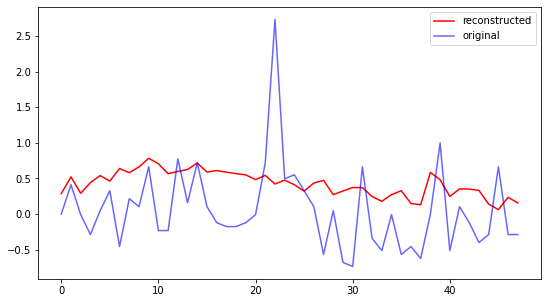

In [88]:
a = 19
b = 12

plt.figure(figsize=(9,5))
plt.plot(cnn_reconstruc_test[a][:,b], label='reconstructed', c='red')
plt.plot(processed_X_test[a][:,b], c='blue', label='original', alpha=0.6)
plt.legend()

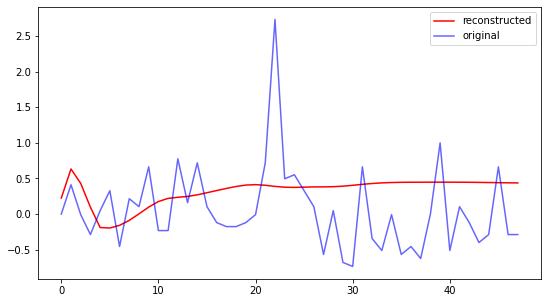

In [89]:
plt.figure(figsize=(9,5))
plt.plot(lstm_reconstruc_test[a][:,b], label='reconstructed', c='red')
plt.plot(processed_X_test[a][:,b], c='blue', label='original', alpha=0.6)
plt.legend()

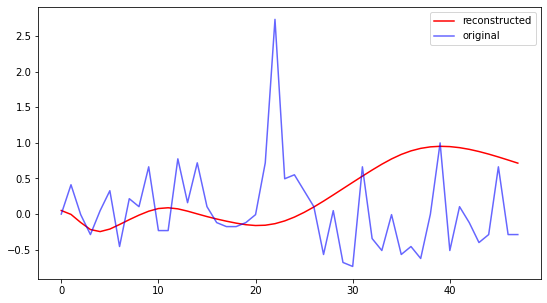

In [90]:
plt.figure(figsize=(9,5))
plt.plot(cnn_lstm_reconstruc_test[a][:,b], label='reconstructed', c='red')
plt.plot(processed_X_test[a][:,b], c='blue', label='original', alpha=0.6)
plt.legend()

In [30]:
def imputed_vae_data(X_train, X_test, reconstruc_train, reconstruc_test):
  
  X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


  # Impute original with reconstruction

  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        if np.isnan(X_train[i,j,k]):
          X_train_imputed[i,j,k] = reconstruc_train[i,j,k]
        else:
          X_train_imputed[i,j,k] = X_train[i,j,k]


  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        if np.isnan(X_test[i,j,k]):
          X_test_imputed[i,j,k] = reconstruc_test[i,j,k]
        else:
          X_test_imputed[i,j,k] = X_test[i,j,k]

  return X_train_imputed, X_test_imputed

In [31]:
cnn_X_train_imputed, cnn_X_test_imputed = imputed_vae_data(X_train, X_test, cnn_reconstruc_train, cnn_reconstruc_test)
lstm_X_train_imputed, lstm_X_test_imputed = imputed_vae_data(X_train, X_test, lstm_reconstruc_train, lstm_reconstruc_test)
cnn_lstm_X_train_imputed, cnn_lstm_X_test_imputed = imputed_vae_data(X_train, X_test, cnn_lstm_reconstruc_train, cnn_lstm_reconstruc_test)



In [32]:
def readm_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
  readm_X_train = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  readm_X_test = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        readm_X_train[i,j,k] = X_train_imputed[i,j,k]



  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        readm_X_test[i,j,k] = X_test_imputed[i,j,k]



  readm_y_train = y_train['readmission_label']
  readm_y_test = y_test['readmission_label']


  rm_idx_train = []
  rm_idx_test = []


  for i in range(readm_X_train.shape[0]):
    if np.isnan(y_train['readmission_label'].values[i]) or y_train['death_label'].values[i] == 1:
      rm_idx_train.append(i)

  for i in range(readm_X_test.shape[0]):
    if np.isnan(y_test['readmission_label'].values[i]) or y_train['death_label'].values[i] == 1:
      rm_idx_test.append(i)

  readm_X_train = np.delete(readm_X_train, rm_idx_train, 0)
  readm_y_train = np.delete(np.array(readm_y_train), rm_idx_train, 0)

  readm_X_test = np.delete(readm_X_test, rm_idx_test, 0)
  readm_y_test = np.delete(np.array(readm_y_test), rm_idx_test, 0)

  print(readm_X_train.shape)
  print(readm_y_train.shape)

  print(readm_X_test.shape)
  print(readm_y_test.shape)

  print(np.where(readm_y_train == 1))
  print(np.where(readm_y_test == 1))  
  return readm_X_train, readm_X_test, readm_y_train, readm_y_test

In [33]:
def mortality_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
  # Processing Data for Mortality
  mortality_X_train = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  mortality_X_test = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        mortality_X_train[i,j,k] = X_train_imputed[i,j,k]


  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        mortality_X_test[i,j,k] = X_test_imputed[i,j,k]

  mortality_y_train = y_train['death_label']
  mortality_y_test = y_test['death_label']


  print(np.where(mortality_y_train == 1))
  print(np.where(mortality_y_test == 1))
  return mortality_X_train, mortality_X_test, mortality_y_train, mortality_y_test

In [34]:
def los_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
  # Processing Data for Length of Stay
  los_X_train = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
  los_X_test = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

  for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      for k in range(X_train.shape[2]):
        los_X_train[i,j,k] = X_train_imputed[i,j,k]


  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      for k in range(X_test.shape[2]):
        los_X_test[i,j,k] = X_test_imputed[i,j,k]

  los_y_train = (y_train['length_of_stay'] - np.full(len(y_train['length_of_stay']), np.mean(y_train['length_of_stay']))) / np.std(y_train['length_of_stay'])
  los_y_test = (y_test['length_of_stay'] - np.full(len(y_test['length_of_stay']), np.mean(y_test['length_of_stay']))) / np.std(y_test['length_of_stay'])
  

  return los_X_train, los_X_test, los_y_train, los_y_test

In [35]:
# Readmission data for each method
readm_mean_X_train, readm_mean_X_test, readm_mean_y_train, readm_mean_y_test = readm_preprocessing(X_train_mean_imputed, 
                                                                               X_test_mean_imputed, y_train, y_test)
readm_cnn_X_train, readm_cnn_X_test, readm_cnn_y_train, readm_cnn_y_test = readm_preprocessing(cnn_X_train_imputed, 
                                                                           cnn_X_test_imputed, y_train, y_test)
readm_lstm_X_train, readm_lstm_X_test, readm_lstm_y_train, readm_lstm_y_test = readm_preprocessing(lstm_X_train_imputed, 
                                                                           lstm_X_test_imputed, y_train, y_test)
readm_cnn_lstm_X_train, readm_cnn_lstm_X_test, readm_cnn_lstm_y_train, readm_cnn_lstm_y_test = readm_preprocessing(cnn_lstm_X_train_imputed, 
                                                                           cnn_lstm_X_test_imputed, y_train, y_test)

# Mortality data for each method
mortality_mean_X_train, mortality_mean_X_test, mortality_mean_y_train, mortality_mean_y_test = mortality_preprocessing(X_train_mean_imputed, 
                                                                               X_test_mean_imputed, y_train, y_test)
mortality_cnn_X_train, mortality_cnn_X_test, mortality_cnn_y_train, mortality_cnn_y_test = mortality_preprocessing(cnn_X_train_imputed, 
                                                                           cnn_X_test_imputed, y_train, y_test)
mortality_lstm_X_train, mortality_lstm_X_test, mortality_lstm_y_train, mortality_lstm_y_test = mortality_preprocessing(lstm_X_train_imputed, 
                                                                           lstm_X_test_imputed, y_train, y_test)
mortality_cnn_lstm_X_train, mortality_cnn_lstm_X_test, mortality_cnn_lstm_y_train, mortality_cnn_lstm_y_test = mortality_preprocessing(cnn_lstm_X_train_imputed, 
                                                                           cnn_lstm_X_test_imputed, y_train, y_test)


# Length of stay data for each method
los_mean_X_train, los_mean_X_test, los_mean_y_train, los_mean_y_test = los_preprocessing(X_train_mean_imputed, 
                                                                               X_test_mean_imputed, y_train, y_test)
los_cnn_X_train, los_cnn_X_test, los_cnn_y_train, los_cnn_y_test = los_preprocessing(cnn_X_train_imputed, 
                                                                           cnn_X_test_imputed, y_train, y_test)
los_lstm_X_train, los_lstm_X_test, los_lstm_y_train, los_lstm_y_test = los_preprocessing(lstm_X_train_imputed, 
                                                                           lstm_X_test_imputed, y_train, y_test)
los_cnn_lstm_X_train, los_cnn_lstm_X_test, los_cnn_lstm_y_train, los_cnn_lstm_y_test = los_preprocessing(cnn_lstm_X_train_imputed, 
                                                                           cnn_lstm_X_test_imputed, y_train, y_test)

(59, 48, 35)
(59,)
(15, 48, 35)
(15,)
(array([ 2,  6, 19, 21, 27, 28, 30, 31, 35, 38, 39, 41, 45, 48, 52, 55, 58]),)
(array([ 3,  8,  9, 10, 13]),)
(59, 48, 35)
(59,)
(15, 48, 35)
(15,)
(array([ 2,  6, 19, 21, 27, 28, 30, 31, 35, 38, 39, 41, 45, 48, 52, 55, 58]),)
(array([ 3,  8,  9, 10, 13]),)
(59, 48, 35)
(59,)
(15, 48, 35)
(15,)
(array([ 2,  6, 19, 21, 27, 28, 30, 31, 35, 38, 39, 41, 45, 48, 52, 55, 58]),)
(array([ 3,  8,  9, 10, 13]),)
(59, 48, 35)
(59,)
(15, 48, 35)
(15,)
(array([ 2,  6, 19, 21, 27, 28, 30, 31, 35, 38, 39, 41, 45, 48, 52, 55, 58]),)
(array([ 3,  8,  9, 10, 13]),)
(array([ 3,  6, 13, 26, 81, 93]),)
(array([ 2,  6,  7, 20]),)
(array([ 3,  6, 13, 26, 81, 93]),)
(array([ 2,  6,  7, 20]),)
(array([ 3,  6, 13, 26, 81, 93]),)
(array([ 2,  6,  7, 20]),)
(array([ 3,  6, 13, 26, 81, 93]),)
(array([ 2,  6,  7, 20]),)


In [36]:
# LSTM Classification Model

es = EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

class_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

class_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.AUC(curve='PR', from_logits=True)])

In [37]:
# LSTM Regression Model

es = EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='loss', mode='auto', restore_best_weights=True)

reg_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(1, activation='relu'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

reg_model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
def train_eval_pred_model(model, batch_size, X_train, X_test, y_train, y_test):
  hist = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, callbacks=[es])

  model.evaluate(X_test, y_test, batch_size=batch_size)

In [ ]:
# Mean Imputation
train_eval_pred_model(class_model, 2, readm_mean_X_train, readm_mean_X_test, readm_mean_y_train, readm_mean_y_test)
train_eval_pred_model(class_model, 2, mortality_mean_X_train, mortality_mean_X_test, mortality_mean_y_train, mortality_mean_y_test)
train_eval_pred_model(reg_model, 1, los_mean_X_train, los_mean_X_test, los_mean_y_train, los_mean_y_test)

Epoch 1/200
31/31 - 2s - loss: 0.6086 - auc: 0.7726 - auc_1: 0.7010 - 2s/epoch - 59ms/step
Epoch 2/200
31/31 - 2s - loss: 0.6070 - auc: 0.7689 - auc_1: 0.6984 - 2s/epoch - 58ms/step
Epoch 3/200
31/31 - 2s - loss: 0.6056 - auc: 0.7659 - auc_1: 0.6919 - 2s/epoch - 57ms/step
Epoch 4/200
31/31 - 2s - loss: 0.6043 - auc: 0.7793 - auc_1: 0.7048 - 2s/epoch - 58ms/step
Epoch 5/200
31/31 - 2s - loss: 0.6030 - auc: 0.7793 - auc_1: 0.7086 - 2s/epoch - 57ms/step
Epoch 6/200
31/31 - 2s - loss: 0.6016 - auc: 0.7659 - auc_1: 0.6884 - 2s/epoch - 57ms/step
Epoch 7/200
31/31 - 2s - loss: 0.6004 - auc: 0.7646 - auc_1: 0.6911 - 2s/epoch - 57ms/step
Epoch 8/200
31/31 - 2s - loss: 0.5992 - auc: 0.7598 - auc_1: 0.6878 - 2s/epoch - 56ms/step
Epoch 9/200
31/31 - 2s - loss: 0.5981 - auc: 0.7579 - auc_1: 0.6902 - 2s/epoch - 55ms/step
Epoch 10/200
31/31 - 2s - loss: 0.5969 - auc: 0.7652 - auc_1: 0.6999 - 2s/epoch - 55ms/step
Epoch 11/200
31/31 - 2s - loss: 0.5957 - auc: 0.7640 - auc_1: 0.6975 - 2s/epoch - 55ms/st

In [ ]:
# cnn-vae
train_eval_pred_model(class_model, 2, readm_cnn_X_train, readm_cnn_X_test, readm_cnn_y_train, readm_cnn_y_test)
train_eval_pred_model(class_model, 2, mortality_cnn_X_train, mortality_cnn_X_test, mortality_cnn_y_train, mortality_cnn_y_test)
train_eval_pred_model(reg_model, 1, los_cnn_X_train, los_cnn_X_test, los_cnn_y_train, los_cnn_y_test)

Epoch 1/200
31/31 - 2s - loss: 0.7599 - auc: 0.8262 - auc_1: 0.6182 - 2s/epoch - 57ms/step
Epoch 2/200
31/31 - 2s - loss: 0.7410 - auc: 0.8354 - auc_1: 0.6463 - 2s/epoch - 59ms/step
Epoch 3/200
31/31 - 2s - loss: 0.7242 - auc: 0.8226 - auc_1: 0.6308 - 2s/epoch - 59ms/step
Epoch 4/200
31/31 - 2s - loss: 0.7110 - auc: 0.8201 - auc_1: 0.6448 - 2s/epoch - 59ms/step
Epoch 5/200
31/31 - 2s - loss: 0.6998 - auc: 0.8244 - auc_1: 0.6409 - 2s/epoch - 60ms/step
Epoch 6/200
31/31 - 2s - loss: 0.6898 - auc: 0.8299 - auc_1: 0.6628 - 2s/epoch - 57ms/step
Epoch 7/200
31/31 - 2s - loss: 0.6805 - auc: 0.8372 - auc_1: 0.6665 - 2s/epoch - 59ms/step
Epoch 8/200
31/31 - 2s - loss: 0.6729 - auc: 0.8250 - auc_1: 0.6477 - 2s/epoch - 57ms/step
Epoch 9/200
31/31 - 2s - loss: 0.6663 - auc: 0.8110 - auc_1: 0.6325 - 2s/epoch - 61ms/step
Epoch 10/200
31/31 - 2s - loss: 0.6593 - auc: 0.8323 - auc_1: 0.6642 - 2s/epoch - 61ms/step
Epoch 11/200
31/31 - 2s - loss: 0.6533 - auc: 0.8317 - auc_1: 0.6646 - 2s/epoch - 57ms/st

In [ ]:
# lstm-vae
train_eval_pred_model(class_model, 2, readm_lstm_X_train, readm_lstm_X_test, readm_lstm_y_train, readm_lstm_y_test)
train_eval_pred_model(class_model, 2, mortality_lstm_X_train, mortality_lstm_X_test, mortality_lstm_y_train, mortality_lstm_y_test)
train_eval_pred_model(reg_model, 1, los_lstm_X_train, los_lstm_X_test, los_lstm_y_train, los_lstm_y_test)

Epoch 1/100
31/31 - 2s - loss: 1.0666 - auc: 0.8549 - auc_1: 0.7090 - 2s/epoch - 57ms/step
Epoch 2/100
31/31 - 2s - loss: 1.0266 - auc: 0.8689 - auc_1: 0.7076 - 2s/epoch - 57ms/step
Epoch 3/100
31/31 - 2s - loss: 0.9892 - auc: 0.8750 - auc_1: 0.7207 - 2s/epoch - 56ms/step
Epoch 4/100
31/31 - 2s - loss: 0.9550 - auc: 0.8713 - auc_1: 0.7090 - 2s/epoch - 56ms/step
Epoch 5/100
31/31 - 2s - loss: 0.9249 - auc: 0.8561 - auc_1: 0.6953 - 2s/epoch - 55ms/step
Epoch 6/100
31/31 - 2s - loss: 0.8960 - auc: 0.8457 - auc_1: 0.6711 - 2s/epoch - 56ms/step
Epoch 7/100
31/31 - 2s - loss: 0.8699 - auc: 0.8671 - auc_1: 0.6979 - 2s/epoch - 56ms/step
Epoch 8/100
31/31 - 2s - loss: 0.8459 - auc: 0.8689 - auc_1: 0.6931 - 2s/epoch - 56ms/step
Epoch 9/100
31/31 - 2s - loss: 0.8248 - auc: 0.8561 - auc_1: 0.6771 - 2s/epoch - 57ms/step
Epoch 10/100
31/31 - 2s - loss: 0.8046 - auc: 0.8463 - auc_1: 0.6623 - 2s/epoch - 56ms/step
Epoch 11/100
31/31 - 2s - loss: 0.7841 - auc: 0.8537 - auc_1: 0.6693 - 2s/epoch - 56ms/st

In [158]:
# cnn-lstm-vae
train_eval_pred_model(class_model, 2, readm_cnn_lstm_X_train, readm_cnn_lstm_X_test, readm_cnn_lstm_y_train, readm_cnn_lstm_y_test)
train_eval_pred_model(class_model, 2, mortality_cnn_lstm_X_train, mortality_cnn_lstm_X_test, mortality_cnn_lstm_y_train, mortality_cnn_lstm_y_test)
train_eval_pred_model(reg_model, 1, los_cnn_lstm_X_train, los_cnn_lstm_X_test, los_cnn_lstm_y_train, los_cnn_lstm_y_test )

Epoch 1/100
31/31 - 2s - loss: 0.5653 - auc: 0.7915 - auc_1: 0.6996 - 2s/epoch - 57ms/step
Epoch 2/100
31/31 - 2s - loss: 0.5625 - auc: 0.7976 - auc_1: 0.7017 - 2s/epoch - 57ms/step
Epoch 3/100
31/31 - 2s - loss: 0.5602 - auc: 0.7951 - auc_1: 0.6982 - 2s/epoch - 59ms/step
Epoch 4/100
31/31 - 2s - loss: 0.5582 - auc: 0.7957 - auc_1: 0.6881 - 2s/epoch - 56ms/step
Epoch 5/100
31/31 - 2s - loss: 0.5562 - auc: 0.7945 - auc_1: 0.6912 - 2s/epoch - 57ms/step
Epoch 6/100
31/31 - 2s - loss: 0.5542 - auc: 0.7957 - auc_1: 0.6995 - 2s/epoch - 56ms/step
Epoch 7/100
31/31 - 2s - loss: 0.5523 - auc: 0.7963 - auc_1: 0.6990 - 2s/epoch - 56ms/step
Epoch 8/100
31/31 - 2s - loss: 0.5507 - auc: 0.7982 - auc_1: 0.7018 - 2s/epoch - 57ms/step
Epoch 9/100
31/31 - 2s - loss: 0.5494 - auc: 0.7963 - auc_1: 0.7001 - 2s/epoch - 56ms/step
Epoch 10/100
31/31 - 2s - loss: 0.5480 - auc: 0.7933 - auc_1: 0.6981 - 2s/epoch - 57ms/step
Epoch 11/100
31/31 - 2s - loss: 0.5465 - auc: 0.7915 - auc_1: 0.6913 - 2s/epoch - 57ms/st